In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

%matplotlib inline

In [2]:
item_to_id = pd.read_csv('item_to_id.csv')
item_to_id.head()

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [3]:
history = pd.read_csv('purchase_history.csv')
history.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


In [4]:
def id_to_item(df):
    ids = df['id'].str.split(',').sum()
    id_list = [0 for i in range(1, 49)]
    for i in ids:
        id_list[int(i)-1] += 1
    return pd.Series(id_list, index=list(range(1, 49)))

In [6]:
# get user_item matrix
user_item_count = history.groupby('user_id').apply(id_to_item)
user_item_count.head()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
68,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
123,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
223,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [7]:
# customers bought the most items
user_count = user_item_count.sum(axis=1).reset_index().rename(columns={0:'count'})
user_count.sort_values(by='count', ascending=False).head()

,user_id,count
4445,269335,72
6111,367872,70
6623,397623,64
9918,599172,64
6291,377284,63


In [12]:
# customer bought most for each item
item_user_most = user_item_count.apply(np.argmax, axis=0).reset_index()
item_user_most = item_user_most.rename(columns={'index':'Item_id', 0:'User_id'})

df = pd.merge(left=item_user_most, right=item_to_id, on='Item_id', how='left')
df[['Item_id', 'Item_name', 'User_id']]

,Item_id,Item_name,User_id
0,1,sugar,512
1,2,lettuce,512
2,3,pet items,2552
3,4,baby items,92
4,5,waffles,3605
5,6,poultry,5555
6,7,sandwich bags,2926
7,8,butter,2493
8,9,soda,4445
9,10,carrots,10238


In [13]:
# define the feature matrix
feature = user_item_count.T
feature.head()

user_id,47,68,113,123,223,281,323,394,420,453,...,1499502,1499523,1499563,1499702,1499727,1499730,1499778,1499797,1499817,1499974
1,0,0,0,0,1,0,1,1,0,1,...,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,1,1,1,...,1,0,1,0,0,0,1,0,2,0
3,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [20]:
# determine the best number of clusters
clusters = range(2, 30)
inertias = []
silhouettes = []

for n_clusters in clusters:
    kmeans = KMeans(n_clusters = n_clusters, init='k-means++', n_jobs=-1)
    kmeans = kmeans.fit(feature)
    label = kmeans.predict(feature)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(feature, label))

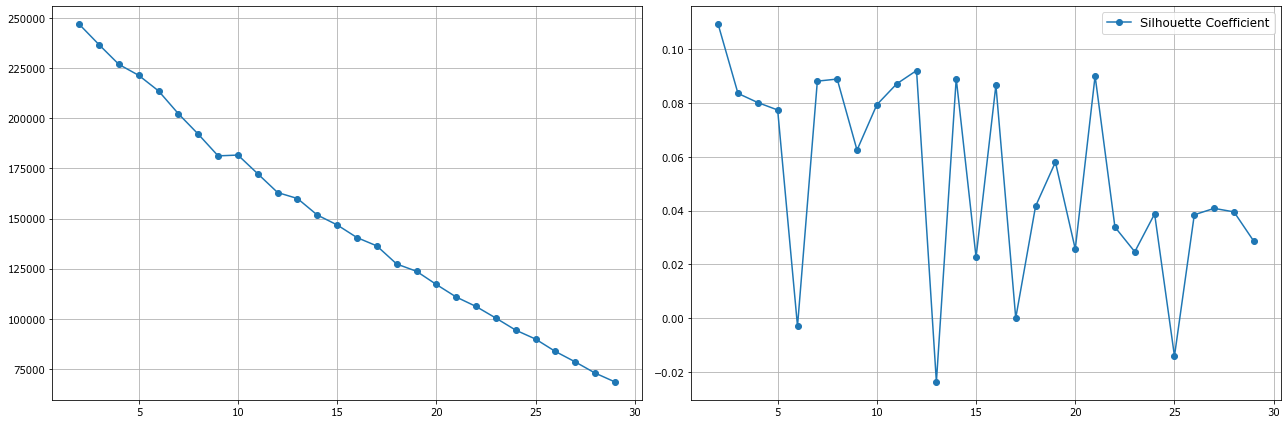

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
ax[0].plot(clusters, inertias, 'o-', label='Sum of Squared Distances')
ax[0].grid(True)
ax[1].plot(clusters, silhouettes, 'o-', label='Silhouette Coefficient')
ax[1].grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [30]:
# build K-Means model with 13 clusters
kmeans = KMeans(n_clusters=13, init='k-means++', n_jobs=-1)
kmeans = kmeans.fit(feature)
label = kmeans.predict(feature)

In [31]:
# PCA for dimension reduction
pca = PCA(n_components=2)
pca = pca.fit(feature)
pca_feature = pca.transform(feature)

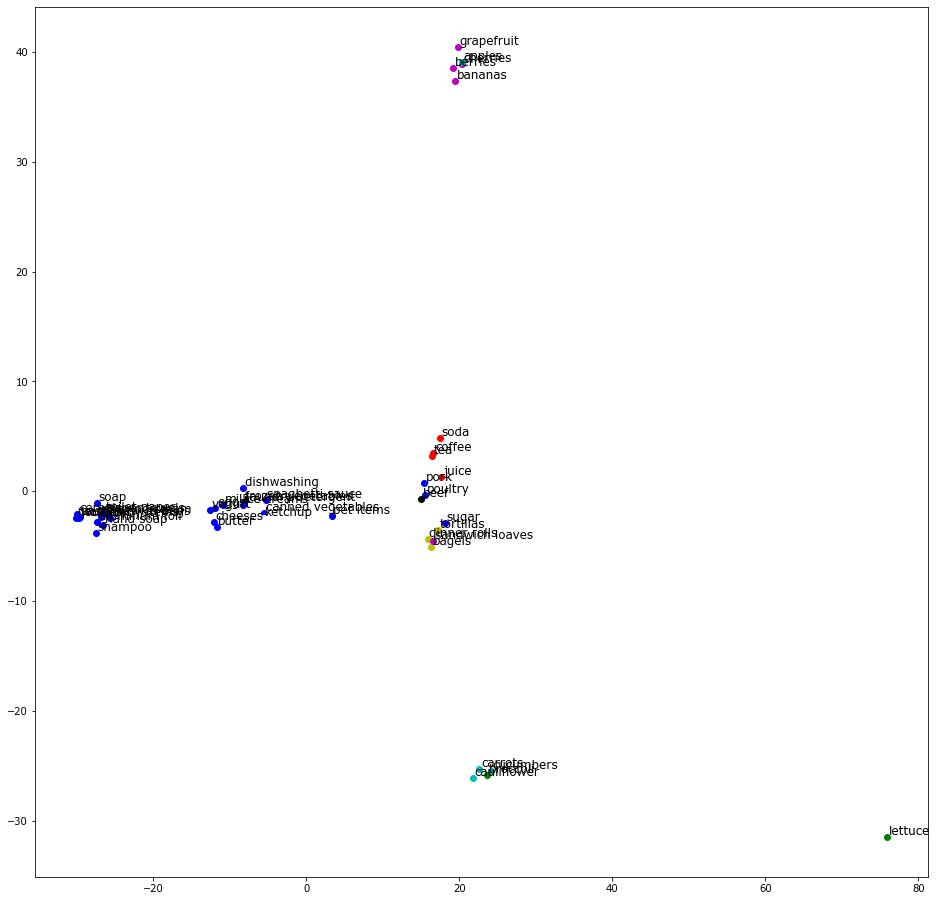

In [32]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

fig, ax = plt.subplots(figsize=(16, 16))
for j in range(len(pca_feature)):
    x = pca_feature[j][0]
    y = pca_feature[j][1]
    ax.plot(x, y, 'o', color=colors[label[j] % 8])
    name = item_to_id[item_to_id['Item_id'] == j + 1]['Item_name']
    ax.annotate(xy=(x+0.2, y+0.2), s=name.values[0], fontsize=12)
    
plt.show()

In [33]:
df = pd.DataFrame({'Item_id': list(range(1,49)), 'label':label})
df = pd.merge(left=df, right=item_to_id, on='Item_id', how='left')

for i in range(0, 13):
    print(i, '\t', list(df[df['label'] == i]['Item_name']))

0 	 ['sugar', 'pet items', 'baby items', 'waffles', 'sandwich bags', 'butter', 'cereals', 'shampoo', 'eggs', 'aluminum foil', 'milk', 'laundry detergent', 'shaving cream', 'cheeses', 'frozen vegetables', 'paper towels', 'spaghetti sauce', 'dishwashing\xa0', 'canned vegetables', 'hand soap', 'flour', 'pasta', 'toilet paper', 'soap', 'ice cream', 'yogurt']
1 	 ['broccoli']
2 	 ['tea', 'coffee']
3 	 ['apples']
4 	 ['grapefruit', 'cherries', 'berries', 'bananas']
5 	 ['bagels', 'tortillas', 'dinner rolls']
6 	 ['beef']
7 	 ['ketchup']
8 	 ['poultry', 'pork']
9 	 ['lettuce']
10 	 ['soda', 'juice']
11 	 ['carrots', 'cucumbers', 'cauliflower']
12 	 ['sandwich loaves']
